In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle
import matplotlib.dates as mdates


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca, gaussian_vel_reconstruction, espra, smooth

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)
    

#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

    

#### Drifter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]
df_drifters.head()


,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00


(np.float64(150.15035),
 np.float64(154.91664999999998),
 np.float64(-38.4239),
 np.float64(-36.4021))

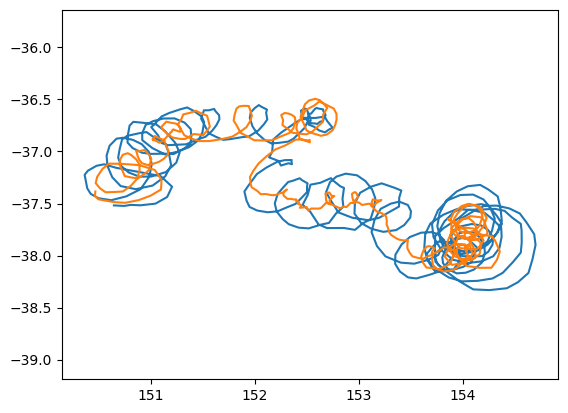

In [4]:
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat)
plt.axis('equal')

In [5]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

Rc_max = np.inf

results = []
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    xi, yi = df_drifters.loc[mask, ['Lon', 'Lat']].values.T
    ui, vi = df_drifters.loc[mask, ['u',   'v'  ]].values.T
    xc, yc, w, Q, Rc, psi0, q = espra(xi, yi, ui, vi) 
    w /= deg_to_m(np.mean(yi))
    results.append(dict(xc=xc, yc=yc, w=w, Q=Q, Rc=Rc, psi0=psi0, q=q, Time=t))

df_results = pd.DataFrame(results)
delta_D_m = np.hypot(df_results.xc.diff(), df_results.yc.diff()) * deg_to_m(df_results.yc)
delta_T_s = df_results.Time.diff().dt.total_seconds()
df_results['Trans_Speed'] = delta_D_m/delta_T_s
df_results


,xc,yc,w,Q,Rc,psi0,q,Time,Trans_Speed
0,154.267637,-37.953826,-1.835220e-07,"[[-0.0072666875310506245, 0.000659990926537592...",13.990430,1.229260,"[[1.1570575958450453, -0.10508880579714731], [...",2023-10-20 12:00:00,NaN
1,154.321904,-37.919899,-2.089448e-07,"[[-0.00860559554466163, 0.0003390979540485265]...",9.724494,0.710723,"[[1.1450234383751772, -0.045118911675031376], ...",2023-10-21 12:00:00,0.104911
2,154.235778,-37.942048,-2.148768e-07,"[[-0.007117291877619892, -0.000389311740622380...",3.345009,0.086580,"[[0.9197914900083614, 0.05031206140509672], [0...",2023-10-22 12:00:00,0.145758
3,154.169484,-37.965548,-2.316670e-07,"[[-0.007361517145338164, -0.000984175162243697...",1.803512,0.028312,"[[0.8457430018016798, 0.11306898287151977], [0...",2023-10-23 12:00:00,0.115270
4,154.153028,-37.911515,-2.248849e-07,"[[-0.007573243318833828, 0.0003533540088296107...",1.433674,0.018329,"[[0.8492533800821783, -0.03962464610345359], [...",2023-10-24 12:00:00,0.092593
...,...,...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-2.496089e-07,"[[-0.008871921026608843, 0.002152433001450708]...",0.406016,-0.046277,"[[-0.031603556416389116, 0.00766739667652864],...",2024-02-04 12:00:00,0.163790
108,150.654736,-37.237212,-2.727406e-07,"[[-0.007806389975327838, 0.0025276662953989913...",0.395485,-0.338239,"[[-0.0036098245276298176, 0.001168841400395358...",2024-02-05 12:00:00,0.088649
109,150.705005,-37.318210,-2.489821e-07,"[[-0.005028825757365147, -0.001447955260680779...",2.119845,0.033418,"[[0.6762385959353692, 0.1947101131960942], [0....",2024-02-06 12:00:00,0.156754
110,150.685157,-37.294499,-3.073088e-07,"[[-0.004910356873446585, -0.002288794605155998...",3.978073,0.115232,"[[0.6743524293415547, 0.3143262785231004], [0....",2024-02-07 12:00:00,0.050852


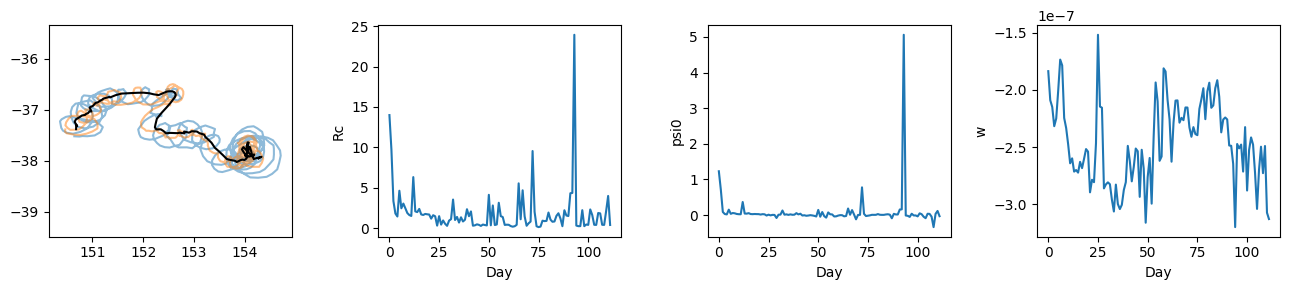

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(13,3))
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    axs[0].plot(df.Lon, df.Lat, alpha=.5) 
axs[0].plot(df_results.xc, df_results.yc, 'k')
axs[0].axis('equal')
axs[1].plot(df_results.Rc)
axs[1].axhline(y=Rc_max, color='r')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Rc')
axs[2].plot(df_results.psi0)
axs[2].set_xlabel('Day')
axs[2].set_ylabel('psi0')
axs[3].plot(df_results.w)
axs[3].set_xlabel('Day')
axs[3].set_ylabel('w')
plt.tight_layout()


Smooth out Q, Rc and psi0

In [7]:
wdw = 10
sQ11 = smooth(df_results.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_results)), num=len(df_results), window=wdw)
sQ12 = smooth(df_results.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_results)), num=len(df_results), window=wdw)
sQ22 = smooth(df_results.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_results)), num=len(df_results), window=wdw)
df_results['sw'] = 2*(sQ11 + sQ22) / deg_to_m(df_results.yc.mean())
df_results['sQ'] = [np.array([[sQ11[i], sQ12[i]], 
                [sQ12[i], sQ22[i]]]) for i in range(len(sQ11))]

Rcs = df_results.Rc.copy()
psi0s = df_results.psi0.copy()

# def fill_between_nans(series: pd.Series) -> pd.Series:
#     """
#     Linearly interpolate only where NaNs are bounded on both sides.
#     Any leading/trailing NaNs are left untouched.
#     """
#     return series.interpolate(
#         method='linear',
#         limit_direction='both',
#         limit_area='inside'
#     )

df_results['sRc'] = smooth(Rcs, np.arange(len(df_results)), num=len(df_results), window=wdw)
df_results['spsi0'] = smooth(psi0s, np.arange(len(df_results)), num=len(df_results), window=wdw)

s = -df_results.sRc**2 / df_results.spsi0
df_results['sq'] = s*df_results['sQ']


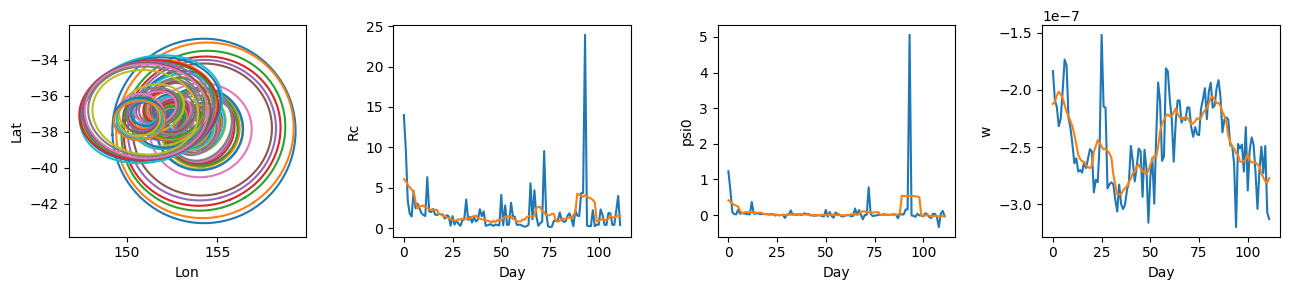

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(13,3))
for (xc, yc, Q, Rc) in zip(df_results.xc, df_results.yc, df_results.sQ, df_results.sRc):
    x_ell, y_ell = plot_ellipse(Q, (xc,yc), scale=Rc)
    axs[0].plot(x_ell, y_ell)
axs[0].axis('equal')
axs[0].set_xlabel('Lon')
axs[0].set_ylabel('Lat')
axs[1].plot(df_results.Rc)
axs[1].plot(df_results.sRc)
axs[1].axhline(y=Rc_max, color='r')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Rc')
axs[2].plot(df_results.psi0)
axs[2].plot(df_results.spsi0)
axs[2].set_xlabel('Day')
axs[2].set_ylabel('psi0')
axs[3].plot(df_results.w)
axs[3].plot(df_results.sw)
axs[3].set_xlabel('Day')
axs[3].set_ylabel('w')
plt.tight_layout()


### SWOT

In [9]:
# lon0, lon1 = df_drifters.Lon.min(), df_drifters.Lon.max()
# lat0, lat1 = df_drifters.Lat.min(), df_drifters.Lat.max()

lon0, lon1 = 150, 155.5
lat0, lat1 = -39, -35

tim0, tim1 = df_drifters.Time.min(), df_drifters.Time.max()

print(lon0, lon1, lat0, lat1, tim0, tim1)


150 155.5 -39 -35 2023-10-19 12:00:00 2024-02-09 18:00:00


(np.float64(150.11035195),
 np.float64(155.75660904999998),
 np.float64(-39.1998819),
 np.float64(-34.80025809999999))

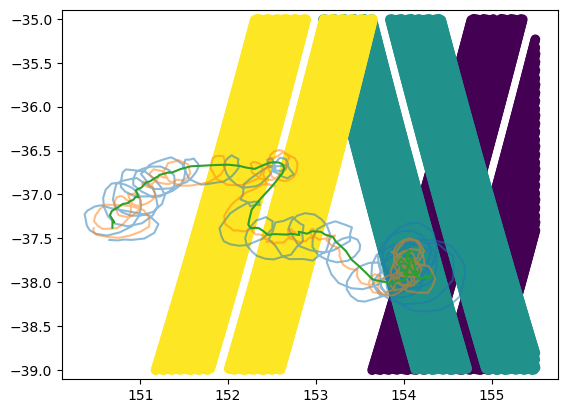

In [10]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot = df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_swot_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
                (df.Lat >= lat0) & (df.Lat <= lat1) &
                (df.Time >= tim0) & (df.Time <= tim1)]

df_swot_CE = df_swot_CE.reset_index().drop(columns=['index'])

# plt.figure(figsize=(15,10))
plt.scatter(df_swot_CE.Lon, df_swot_CE.Lat, c=df_swot_CE.ID)
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat, alpha=.5)
    
plt.plot(df_results.xc, df_results.yc)
plt.axis('equal')


#### Gameday plot

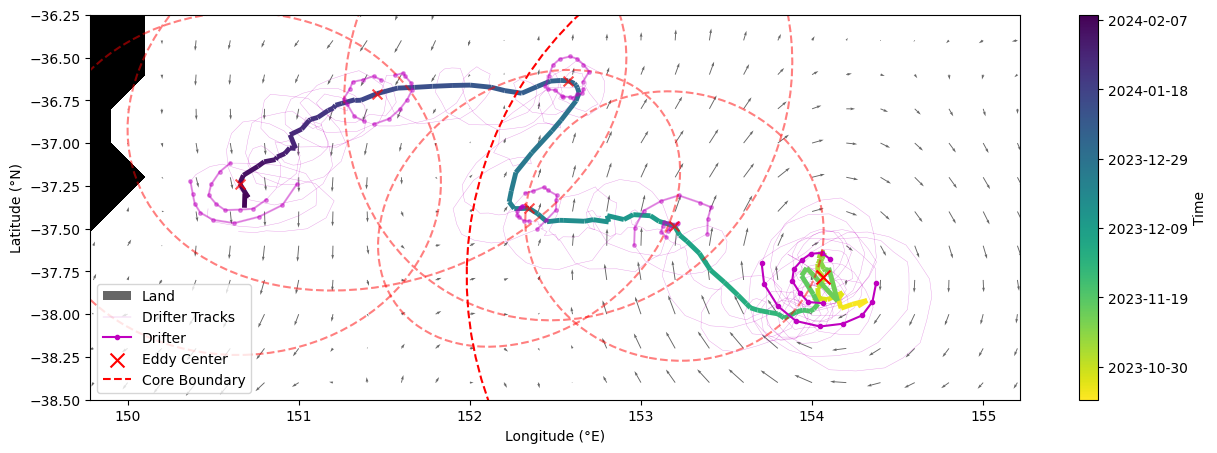

In [11]:
Rc_plot_scale = 1

plt.figure(figsize=(15, 5))
# time & SSH data
t = pd.Timestamp('2023-11-01 12:00:00')
closest = min(tim_ssh, key=lambda tt: abs(tt - t))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
# make a boolean mask: True where either component is NaN (i.e. land)
mask = np.isnan(ut) | np.isnan(vt)
# plot only valid ocean vectors
plt.quiver(
    lon_ssh[~mask], lat_ssh[~mask],
    ut[~mask], vt[~mask],
    scale=30, width=0.001, alpha=.6,
    label='Land'
)
# create an integer mask (0=ocean, 1=land)
land_mask = mask.astype(int)
# fill land with solid black
plt.contourf(
    lon_ssh, lat_ssh, land_mask,
    levels=[0.5, 1.5],        # anything ≥0.5 is land
    colors=['k'],             # black fill
    alpha=1
)
# full drifter tracks
for idx, d in enumerate(df_drifters.ID.unique()):
    df = df_drifters[df_drifters.ID == d]
    plt.plot(df.Lon, df.Lat, alpha=0.4, linewidth=0.3, color='m', label='Drifter Tracks' if idx ==0 else '')

import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
# convert timestamps to floats
times = mdates.date2num(df_results.Time)
# build line segments between each pair of points
pts = np.vstack([df_results.xc, df_results.yc]).T.reshape(-1,1,2)
segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
# create the coloured line
lc = LineCollection(segs, array=times,
                    cmap='viridis_r',     # pick any colormap you like
                    linewidth=3.5, alpha=1)
ax = plt.gca()
ax.add_collection(lc)
# add a colourbar (will label in “date” units)
cbar = plt.colorbar(lc)
cbar.set_label('Time')
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y‑%m‑%d'))
# highlight drifter positions ±1 day around t
w0, w1 = t - pd.Timedelta(days=1), t + pd.Timedelta(days=1)
for idx, d in enumerate(df_drifters.ID.unique()):
    dd = df_drifters[
        (df_drifters.ID == d) &
        (df_drifters.Time >= w0) &
        (df_drifters.Time <= w1)
    ]
    plt.plot(
        dd.Lon, dd.Lat,
        alpha=1, marker='.', linewidth=1.5, color='m', label='Drifter' if idx ==0 else ''
    )
# marker at the eddy center at exactly t
data = df_results[df_results.Time == t].iloc[0]
plt.scatter(data.xc, data.yc, marker='x', color='r', s=100, label='Eddy Center', zorder=10)
x_ell, y_ell =plot_ellipse(data.sQ, (data.xc, data.yc), scale=data.sRc)
plt.plot(x_ell, y_ell, 'r--', label='Core Boundary')

# Show other ones
for t in [pd.Timestamp('2023-12-8 12:00:00'), pd.Timestamp('2023-12-21 12:00:00'), pd.Timestamp('2024-01-03 12:00:00'),
          pd.Timestamp('2024-01-15 12:00:00'), pd.Timestamp('2024-02-05 12:00:00')]:
    # highlight drifter positions ±1 day around t
    w0, w1 = t - pd.Timedelta(days=1), t + pd.Timedelta(days=1)
    for idx, d in enumerate(df_drifters.ID.unique()):
        dd = df_drifters[
            (df_drifters.ID == d) &
            (df_drifters.Time >= w0) &
            (df_drifters.Time <= w1)
        ]
        plt.plot(
            dd.Lon, dd.Lat,
            alpha=.4, marker='.', linewidth=1.5, color='m', markersize=5
        )
    # marker at the eddy center at exactly t
    data = df_results[df_results.Time == t].iloc[0]
    plt.scatter(data.xc, data.yc, marker='x', color='r', s=50, zorder=10, alpha=.7)
    x_ell, y_ell = plot_ellipse(data.sQ, (data.xc, data.yc), scale=data.sRc)
    plt.plot(x_ell, y_ell, 'r--', alpha=.5)
    
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.axis('equal')
plt.xlim(150, 155)
plt.ylim(-38.5, -36.25)
plt.legend(loc='lower left')
plt.show()


In [12]:
# import matplotlib.dates as mdates
# from matplotlib.collections import LineCollection
# import matplotlib.animation as animation

# # PARAMETERS
# Rc_plot_scale = .4
# times = df_results.Time.values
# n_frames = len(times)

# # SET UP FIGURE & AXES
# fig, ax = plt.subplots(figsize=(15, 5))

# def init():
#     ax.clear()
#     ax.set_xlabel('Longitude (°E)')
#     ax.set_ylabel('Latitude (°N)')
#     ax.axis('equal')
#     ax.set_xlim(150, 155)
#     ax.set_ylim(-38.5, -36.25)
#     return []

# def update(frame):
#     t = times[frame]
#     ax.clear()
#     ax.set_title(t.astype('datetime64[D]'))
#     ax.set_xlabel('Longitude (°E)')
#     ax.set_ylabel('Latitude (°N)')
#     ax.axis('equal')
#     ax.set_xlim(150, 155)
#     ax.set_ylim(-38.5, -36.25)

#     # --- SSH vectors & land mask ---
#     closest = min(tim_ssh, key=lambda tt: abs(tt - t))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = np.isnan(ut) | np.isnan(vt)
#     ax.quiver(
#         lon_ssh[~mask], lat_ssh[~mask],
#         ut[~mask], vt[~mask],
#         scale=30, width=0.001, alpha=.6
#     )
#     land_mask = mask.astype(int)
#     ax.contourf(
#         lon_ssh, lat_ssh, land_mask,
#         levels=[0.5, 1.5], colors=['k'], alpha=1
#     )

#     # --- Highlight drifters ±1 day around t ---
#     w0, w1 = t - pd.Timedelta(days=1), t + pd.Timedelta(days=1)
#     for idx, d in enumerate(df_drifters.ID.unique()):
#         dd = df_drifters[
#             (df_drifters.ID == d) &
#             (df_drifters.Time >= w0) &
#             (df_drifters.Time <= w1)
#         ]
#         ax.plot(dd.Lon, dd.Lat, marker='.', markersize=4,
#                 linewidth=1.5, alpha=1, color='m',
#                 label='Drifter' if idx == 0 else '')

#     # --- Eddy core & ellipse at exactly t ---
#     data = df_results[df_results.Time == t].iloc[0]
#     ax.scatter(data.xc, data.yc, marker='x', color='r', s=100, zorder=10, label='Eddy Center')
#     x_ell, y_ell = plot_ellipse(data.sQ, (data.xc, data.yc), scale=Rc_plot_scale)#data.sRc)
#     ax.plot(x_ell, y_ell, 'r-', label='Eddy Deformation')

#     # OPTIONAL: one legend call
#     # if frame == 0:
#     ax.legend(loc='lower left')

#     return []

# # CREATE THE ANIMATION
# ani = animation.FuncAnimation(
#     fig, update, frames=n_frames,
#     init_func=init, blit=False, repeat=True
# )

# # # To display inline in a Jupyter notebook:
# # plt.close(fig)
# # from IPython.display import HTML
# # HTML(ani.to_jshtml())

# # — OR — to save to file:
# ani.save(
#     '2Drifter_animation.gif',
#     writer='pillow',
#     fps=3,
#     dpi=150
# )


In [13]:
# import matplotlib.dates as mdates
# from matplotlib.collections import LineCollection
# import matplotlib.animation as animation

# # PARAMETERS
# Rc_plot_scale = .4
# times = df_results.Time.values
# n_frames = len(times)

# # SET UP FIGURE & AXES
# fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# def init():
#     ax.clear()
#     ax.set_xlabel('Longitude (°E)')
#     ax.set_ylabel('Latitude (°N)')
#     ax.axis('equal')
#     ax.set_xlim(150, 155)
#     ax.set_ylim(-38.5, -36.25)
#     return []

# def update(frame):

#     ax = axs[0]
#     t = times[frame]
#     ax.clear()
#     ax.set_title(t.astype('datetime64[D]'))
#     ax.set_xlabel('Longitude (°E)')
#     ax.set_ylabel('Latitude (°N)')
#     ax.axis('equal')
#     ax.set_xlim(150, 155)
#     ax.set_ylim(-38.5, -36.25)

#     # --- SSH vectors & land mask ---
#     closest = min(tim_ssh, key=lambda tt: abs(tt - t))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = np.isnan(ut) | np.isnan(vt)
#     ax.quiver(
#         lon_ssh[~mask], lat_ssh[~mask],
#         ut[~mask], vt[~mask],
#         scale=30, width=0.001, alpha=.6
#     )
#     land_mask = mask.astype(int)
#     ax.contourf(
#         lon_ssh, lat_ssh, land_mask,
#         levels=[0.5, 1.5], colors=['k'], alpha=1
#     )

#     # --- Highlight drifters ±1 day around t ---
#     w0, w1 = t - pd.Timedelta(days=1), t + pd.Timedelta(days=1)
#     for idx, d in enumerate(df_drifters.ID.unique()):
#         dd = df_drifters[
#             (df_drifters.ID == d) &
#             (df_drifters.Time >= w0) &
#             (df_drifters.Time <= w1)
#         ]
#         ax.plot(dd.Lon, dd.Lat, marker='.', markersize=4,
#                 linewidth=1.5, alpha=1, color='m',
#                 label='Drifter' if idx == 0 else '')

#     # --- Eddy core & ellipse at exactly t ---
#     data = df_results[df_results.Time == t].iloc[0]
#     ax.scatter(data.xc, data.yc, marker='x', color='r', s=100, zorder=10, label='Eddy Center')
#     x_ell, y_ell = plot_ellipse(data.sQ, (data.xc, data.yc), scale=Rc_plot_scale)#data.sRc)
#     ax.plot(x_ell, y_ell, 'r-', label='Eddy Deformation')

#     # OPTIONAL: one legend call
#     # if frame == 0:
#     ax.legend(loc='lower left')

#     ax = axs[1]
#     ax2 = ax.twinx()
    
#     # inside loop
#     ax.clear()
#     # ax2.clear()
    
#     df = df_results[df_results.Time <= t].copy()
    
#     ax.plot(df.Time, df.sw, 'b')
#     ax.set_xlim(df_results.Time.min(), df_results.Time.max())
#     ax.set_ylim(df_results.sw.min(), df_results.sw.max())
#     ax.set_ylabel('sw', color='b')
    
#     # ax2.plot(df.Time, df.sRc, 'r')
#     # ax2.plot(df.Time, df.spsi0, 'g')
#     # ax2.set_ylabel(r'$R_c$ - $\psi_0$', color='r')
        
#     return []

# # CREATE THE ANIMATION
# ani = animation.FuncAnimation(
#     fig, update, frames=n_frames,
#     init_func=init, blit=False, repeat=True
# )

# # # To display inline in a Jupyter notebook:
# # plt.close(fig)
# # from IPython.display import HTML
# # HTML(ani.to_jshtml())

# # — OR — to save to file:
# ani.save(
#     '2Drifter_animation.gif',
#     writer='pillow',
#     fps=3,
#     dpi=150
# )


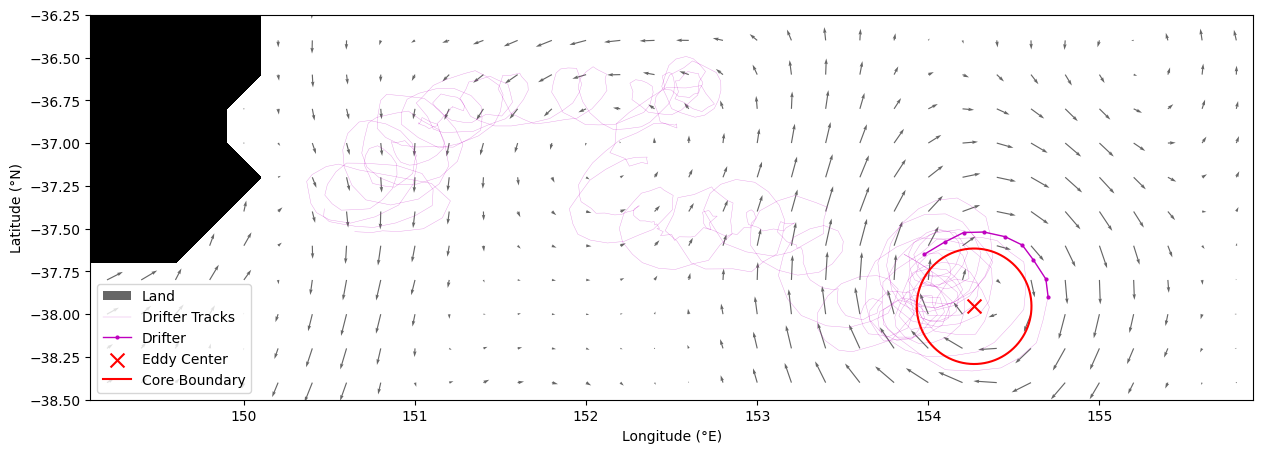

In [14]:
Rc_plot_scale = .4
# Rc_plot_scale = 1

plt.figure(figsize=(15, 5))
# time & SSH data
t  = df_results.Time.iloc[0]

closest = min(tim_ssh, key=lambda tt: abs(tt - t))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
# make a boolean mask: True where either component is NaN (i.e. land)
mask = np.isnan(ut) | np.isnan(vt)
# plot only valid ocean vectors
plt.quiver(
    lon_ssh[~mask], lat_ssh[~mask],
    ut[~mask], vt[~mask],
    scale=30, width=0.001, alpha=.6,
    label='Land', 
)
# create an integer mask (0=ocean, 1=land)
land_mask = mask.astype(int)
# fill land with solid black
plt.contourf(
    lon_ssh, lat_ssh, land_mask,
    levels=[0.5, 1.5],        # anything ≥0.5 is land
    colors=['k'],             # black fill
    alpha=1
)
# full drifter tracks
for idx, d in enumerate(df_drifters.ID.unique()):
    df = df_drifters[df_drifters.ID == d]
    plt.plot(df.Lon, df.Lat, alpha=0.4, linewidth=0.3, color='m', label='Drifter Tracks' if idx ==0 else '')

# highlight drifter positions ±1 day around t
w0, w1 = t - pd.Timedelta(days=1), t + pd.Timedelta(days=1)
for idx, d in enumerate(df_drifters.ID.unique()):
    dd = df_drifters[
        (df_drifters.ID == d) &
        (df_drifters.Time >= w0) &
        (df_drifters.Time <= w1)
        ]
    plt.plot(
        dd.Lon, dd.Lat,
        alpha=1, marker='.', markersize=4, linewidth=1, color='m', label='Drifter' if idx ==0 else ''
        )
    
# marker at the eddy center at exactly t
data = df_results[df_results.Time == t].iloc[0]
plt.scatter(data.xc, data.yc, marker='x', color='r', s=100, label='Eddy Center', zorder=10)
x_ell, y_ell =plot_ellipse(data.sQ, (data.xc, data.yc), scale=Rc_plot_scale)#*data.Rc)
plt.plot(x_ell, y_ell, 'r-', label='Core Boundary')


plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.axis('equal')
plt.xlim(150, 155)
plt.ylim(-38.5, -36.25)
plt.legend(loc='lower left')
plt.show()



### IMOS ESPRA APP

In [15]:
initial_data = df_results.iloc[0]

xc_old, yc_old = initial_data.xc, initial_data.yc
results = []
Search_Radius = .5
for t, time in enumerate(tim_ssh):
    
    ut = dic_ssh_data[time]['u']
    vt = dic_ssh_data[time]['v']
    
    mask = np.hypot(lon_ssh - xc_old, lat_ssh - yc_old) < Search_Radius
    xi, yi = lon_ssh[mask], lat_ssh[mask]
    ui, vi = ut[mask], vt[mask]
    xc, yc, w, Q, Rc, psi0, q = espra(xi, yi, ui, vi) 
    w /= deg_to_m(np.mean(yi))  
    
    if np.hypot(xc-xc_old, yc-yc_old) < 1:
        results.append(dict(xc=xc, yc=yc, w=w, Q=Q, Rc=Rc, psi0=psi0, q=q, Time=time))
        xc_old, yc_old = xc, yc
    else:
        break
        
df_IMOS_results = pd.DataFrame(results)
delta_D_m = np.hypot(df_IMOS_results.xc.diff(), df_IMOS_results.yc.diff()) * deg_to_m(df_IMOS_results.yc)
delta_T_s = df_results.Time.diff().dt.total_seconds()
df_IMOS_results['Trans_Speed'] = delta_D_m/delta_T_s
df_IMOS_results


,xc,yc,w,Q,Rc,psi0,q,Time,Trans_Speed
0,154.344917,-37.857942,-0.000018,"[[-0.6777860175199772, -0.02503222183750707], ...",2.142721,3.253201,"[[0.956561414212151, 0.03532804882781799], [0....",2023-10-18 18:00:00,NaN
1,154.346018,-37.837175,-0.000018,"[[-0.7116502377000414, -0.01567780559586537], ...",2.353078,3.829716,"[[1.0288987034904469, 0.022666856549214374], [...",2023-10-19 18:00:00,0.034105
2,154.353370,-37.840455,-0.000020,"[[-0.7764619930051677, -0.041086610952159514],...",2.265970,3.801595,"[[1.0487273411416453, 0.05549357553691965], [0...",2023-10-20 18:00:00,0.013202
3,154.331273,-37.824949,-0.000019,"[[-0.7365988019982715, -0.014556528266862873],...",2.320402,3.846225,"[[1.0311526470856462, 0.020377446466153644], [...",2023-10-21 18:00:00,0.044272
4,154.320855,-37.822351,-0.000018,"[[-0.7097957223345088, -0.031157480452973604],...",2.227723,3.368531,"[[1.0457199914058428, 0.04590334819763283], [0...",2023-10-22 18:00:00,0.017610
...,...,...,...,...,...,...,...,...,...
115,150.522746,-37.019753,-0.000008,"[[-0.37714074385808355, 0.0027171620419192575]...",0.665523,-4.457535,"[[-0.03747437693328344, 0.0002699892711300593]...",2024-02-06 06:00:00,NaN
116,150.560480,-36.948239,-0.000007,"[[-0.38294843827977476, 0.022416244323168102],...",0.625871,-2.096707,"[[-0.07154393552861323, 0.004187891053569762],...",2024-02-07 06:00:00,NaN
117,150.611650,-36.881797,-0.000005,"[[-0.33098453422116186, 0.025035085940031163],...",2.585145,1.620231,"[[1.365213681359309, -0.10326235308776974], [-...",2024-02-08 06:00:00,NaN
118,150.619133,-36.869669,-0.000004,"[[-0.3399480645549203, 0.06386082886702155], [...",0.547565,0.422125,"[[0.24145881869618588, -0.045359164845897124],...",2024-02-09 06:00:00,NaN


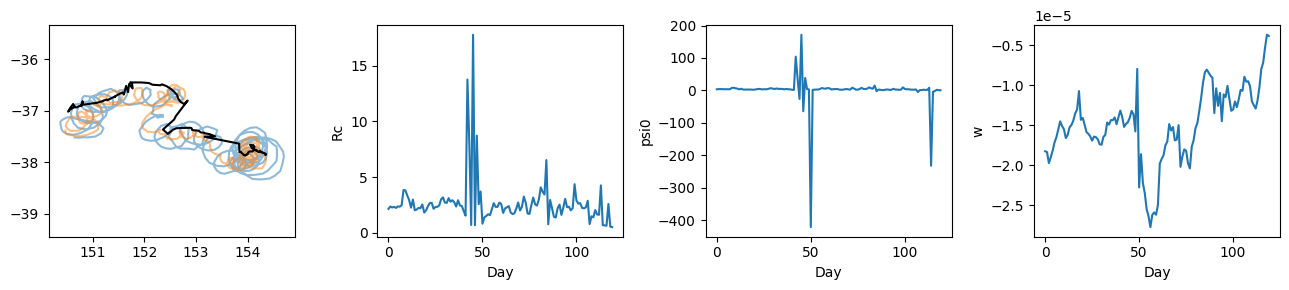

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(13,3))
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    axs[0].plot(df.Lon, df.Lat, alpha=.5) 
axs[0].plot(df_IMOS_results.xc, df_IMOS_results.yc, 'k')
axs[0].axis('equal')
axs[1].plot(df_IMOS_results.Rc)
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Rc')
axs[2].plot(df_IMOS_results.psi0)
axs[2].set_xlabel('Day')
axs[2].set_ylabel('psi0')
axs[3].plot(df_IMOS_results.w)
axs[3].set_xlabel('Day')
axs[3].set_ylabel('w')
plt.tight_layout()


In [17]:
wdw = 10
q11 = smooth(df_IMOS_results.Q.apply(lambda Q: Q[0, 0]), np.arange(len(df_IMOS_results)), num=len(df_IMOS_results), window=wdw)
q12 = smooth(df_IMOS_results.Q.apply(lambda Q: Q[0, 1]), np.arange(len(df_IMOS_results)), num=len(df_IMOS_results), window=wdw)
q22 = smooth(df_IMOS_results.Q.apply(lambda Q: Q[1, 1]), np.arange(len(df_IMOS_results)), num=len(df_IMOS_results), window=wdw)
df_IMOS_results['sw'] = 2*(q11 + q22) / deg_to_m(df_IMOS_results.yc.mean())
df_IMOS_results['sQ'] = [np.array([[q11[i], q12[i]], 
                [q12[i], q22[i]]]) for i in range(len(q11))]

Rcs = df_IMOS_results.Rc.copy()
psi0s = df_IMOS_results.psi0.copy()

df_IMOS_results['sRc'] = smooth(Rcs, np.arange(len(df_IMOS_results)), num=len(df_IMOS_results), window=wdw)
df_IMOS_results['spsi0'] = smooth(psi0s, np.arange(len(df_IMOS_results)), num=len(df_IMOS_results), window=wdw)

s = -df_IMOS_results.sRc**2 / df_IMOS_results.spsi0
df_IMOS_results['sq'] = s*df_IMOS_results['sQ']


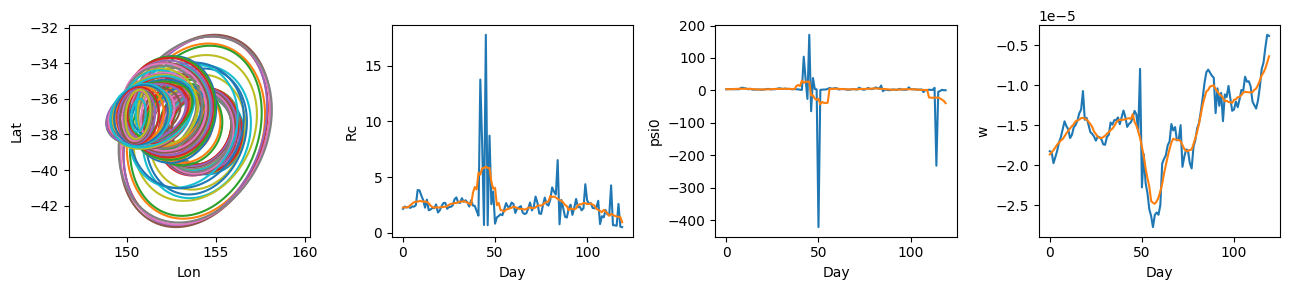

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(13,3))
for (xc, yc, Q, Rc) in zip(df_IMOS_results.xc, df_IMOS_results.yc, df_IMOS_results.sQ, df_IMOS_results.sRc):
    x_ell, y_ell = plot_ellipse(Q, (xc,yc), scale=Rc)
    axs[0].plot(x_ell, y_ell)
axs[0].axis('equal')
axs[0].set_xlabel('Lon')
axs[0].set_ylabel('Lat')
axs[1].plot(df_IMOS_results.Rc)
axs[1].plot(df_IMOS_results.sRc)
axs[1].axhline(y=Rc_max, color='r')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Rc')
axs[2].plot(df_IMOS_results.psi0)
axs[2].plot(df_IMOS_results.spsi0)
axs[2].set_xlabel('Day')
axs[2].set_ylabel('psi0')
axs[3].plot(df_IMOS_results.w)
axs[3].plot(df_IMOS_results.sw)
axs[3].set_xlabel('Day')
axs[3].set_ylabel('w')
plt.tight_layout()


### Compare Results

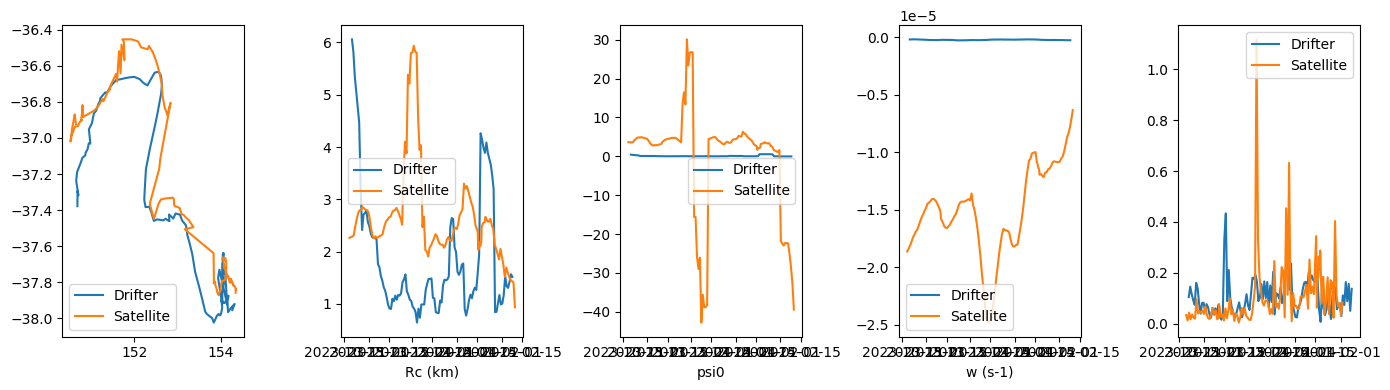

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(14,4))

axs[0].plot(df_results.xc, df_results.yc, label='Drifter')
axs[0].plot(df_IMOS_results.xc, df_IMOS_results.yc, label='Satellite')
axs[0].legend()
axs[1].plot(df_results.Time, df_results.sRc, label='Drifter')
axs[1].plot(df_IMOS_results.Time, df_IMOS_results.sRc, label='Satellite')
axs[1].set_xlabel('Rc (km)')
axs[1].legend()
axs[2].plot(df_results.Time, df_results.spsi0, label='Drifter')
axs[2].plot(df_IMOS_results.Time, df_IMOS_results.spsi0, label='Satellite')
axs[2].set_xlabel('psi0')
axs[2].legend()
axs[3].plot(df_results.Time, df_results.sw, label='Drifter')
axs[3].plot(df_IMOS_results.Time, df_IMOS_results.sw, label='Satellite')
axs[3].legend()
axs[3].set_xlabel('w (s-1)')
axs[4].plot(df_results.Time, df_results.Trans_Speed, label='Drifter')
axs[4].plot(df_IMOS_results.Time, df_IMOS_results.Trans_Speed, label='Satellite')
axs[4].legend()
plt.tight_layout()


#### Reco

In [20]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.figure(figsize=(15, 5))
# time & SSH data
t = pd.Timestamp('2023-11-01 12:00:00')
closest = min(tim_ssh, key=lambda tt: abs(tt - t))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
# make a boolean mask: True where either component is NaN (i.e. land)
mask = np.isnan(ut) | np.isnan(vt)
# plot only valid ocean vectors
plt.quiver(
    lon_ssh[~mask], lat_ssh[~mask],
    ut[~mask], vt[~mask],
    scale=30, width=0.001,
    label='Land'
)
# create an integer mask (0=ocean, 1=land)
land_mask = mask.astype(int)
# fill land with solid black
plt.contourf(
    lon_ssh, lat_ssh, land_mask,
    levels=[0.5, 1.5],        # anything ≥0.5 is land
    colors=['k'],             # black fill
    alpha=1,
)

data = df_results[df_results.Time == t].iloc[0]

u_reco, v_reco, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.q[0,0], data.q[0,1], data.q[1,1], .00001, .5, X=lon_ssh, Y=lat_ssh)

plt.quiver(lon_ssh, lat_ssh, u_reco, v_reco, scale=30, width=0.001, color='r')

plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.axis('equal')
plt.xlim(150, 155)
plt.ylim(-38.5, -36.25)
plt.legend(loc='lower left')
plt.show()


In [ ]:
u_reco, v_reco, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.q[0,0], data.q[0,1], data.q[1,1], .0000001, .5, X=lon_ssh, Y=lat_ssh)

plt.figure(figsize=(15, 5))
plt.quiver(lon_ssh, lat_ssh, u_reco, v_reco)#, scale=30, width=0.001)
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.axis('equal')
plt.xlim(150, 155)
plt.ylim(-38.5, -36.25)

u_reco.max()



In [ ]:
data.Rc - .000001


In [ ]:
data.psi0